In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, hex2color, rgb2hex
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.ticker as ticker
import pandas as pd
import scipy
import seaborn as sns
from matplotlib import gridspec
from scipy.optimize import curve_fit

In [8]:
import popoff
import pop_off_functions as pof
import pop_off_plotting as pop
from Session import SessionLite
from linear_model import PoolAcrossSessions, LinearModel, MultiSessionModel

user_paths_dict = popoff.loadpaths.loadpaths()
sys.path.append(user_paths_dict['vape_path'])
from utils.utils_funcs import d_prime

figure_path = '/home/jrowland/Documents/figures/s1s2_paper/0'

## Panels and b are rob's from fens figure

## Panel C

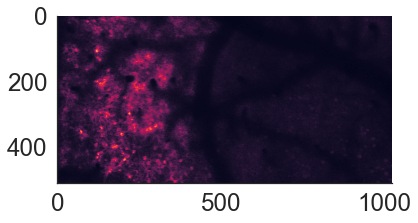

In [5]:
# I'm currently not using the image out of python, I did the central pixel selection and png saving in imagej.
# But this is the path to the correct image used in figure 1

tiff_path = os.path.expanduser('~/mnt/qnap/Data/2020-02-21/STA/2020-02-21_RL070_t-001/'
                               '2020-02-21_RL070_t-001_17Stims_STA_dF_MaxResponseImage.tif')

image = tifffile.imread(tiff_path)
# Select the central 512 lines
image = image[int(512 - (1024 / 4)):int(512 + (1024 / 4)), :]
plt.imshow(image)

## Panel d

In [83]:
msm = MultiSessionModel(remove_targets=False, subsample_sessions=False,
                         remove_toosoon=True)
# print(msm.plot_string('Both', is_plot=False))

long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
ALERT SESSIONS NOT SUBSAMPLED
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time


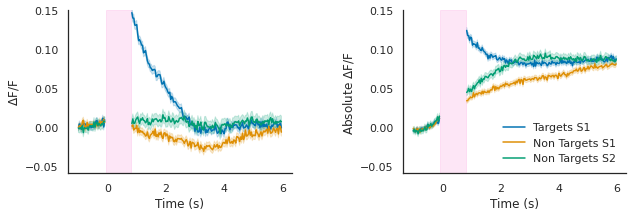

In [126]:
lm = msm.linear_models[6]

fig, ax = plt.subplots(1, 2, figsize=(10, 3), gridspec_kw={'wspace': 0.5})
filter_150 = False

for i_ax, absolute_dff in enumerate([False, True]):
    pop.get_plot_trace(lm, targets=True, region='s1', ax=ax[i_ax], plot_artefact=True,
                       absolute_vals=absolute_dff, filter_150_stim=filter_150)
    pop.get_plot_trace(lm, targets=False, region='s1', i_col=1, ax=ax[i_ax],
                       absolute_vals=absolute_dff, filter_150_stim=filter_150)
    pop.get_plot_trace(lm, targets=False, region='s2', i_col=2, ax=ax[i_ax],
                       absolute_vals=absolute_dff, plot_legend=(i_ax == 1), 
                       filter_150_stim=filter_150)


In [46]:
subset_dprimes = [pof.get_subset_dprime(lm.session) for lm in msm.linear_models]
subset_dprimes = np.array(subset_dprimes)

/home/tplas/repos/popping-off/popoff/popoff/pop_off_functions.py:1763: RuntimeWarning: overflow encountered in exp


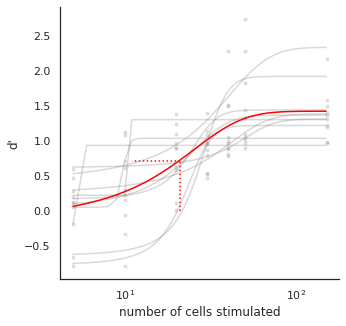

In [48]:
pop.plot_accuracy_n_cells_stim(subset_dprimes=subset_dprimes)

In [54]:
pof.get_alltrials_dprime(session=msm.linear_models[4].session)

1.0291718832869603

In [43]:
# import utils
utils.utils_funcs

<module 'utils.utils_funcs' from '/home/tplas/repos/Vape/utils/utils_funcs.py'>

## Raw data of the above figure

In [30]:
# plt.figure(figsize=(5,5))
# x_axis = [7.5, 25, 45, 150]

# for dp in subset_dprimes:
#     plt.plot(x_axis, dp, marker='o', color='blue', markersize=10)
# plt.xlabel('n cells stimmed')
# plt.ylabel('d\'')

## Lick raster -> reorder the panel letters

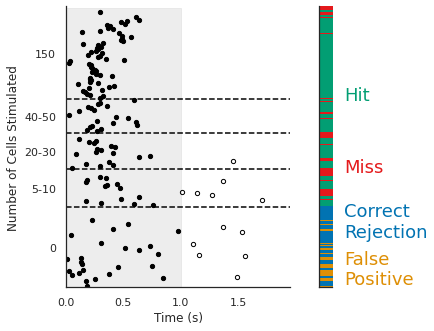

In [36]:
lm = msm.linear_models[2]
pop.lick_raster(lm)
# save_figure('Lick_raster', figure_path)

## Hex color codes for the seaborn palette

In [38]:

# np.seterr(divide='ignore')  # Ugly division by 0 error
# plt.figure(figsize=(10,10))

# x_axis = [7.5, 25, 45, 150]
# # x_axis = [5,10,20,30,40,50,150]
# all_dp = []
# n = 0

# min_x = 5
# for idx, dp in enumerate(subset_dprimes):
    
#     all_dp.append(dp)
#     plt.plot(x_axis, dp, '.', color='grey', alpha=1, markersize=10)
    
#     popt, pcov = curve_fit(pf, x_axis, dp, method='dogbox', p0=[max(dp), 50, 200])
    
#     plt.plot(np.arange(min_x ,max(x_axis)), pof.pf(np.arange(min_x, max(x_axis)), *popt), color='grey', alpha=0.8)
#     plt.xscale('log')
    
# y = np.concatenate(all_dp)
# x = np.tile(x_axis, subset_dprimes.shape[0])
# popt, pcov = curve_fit(pf, x, y, method='dogbox', p0=[max(y), 50, 200])
# plt.plot(np.arange(min_x, max(x_axis)), pof.pf(np.arange(min_x, max(x_axis)), *popt), color='red')

# plt.xscale('log')
# plt.ylabel('d\'')
# plt.xlabel('number of cells stimulated', fontname='Arial')

# ticks = [5, int(popt[1]), 100, 150]
# ticks = [10,100]

# # plt.axvline(x=popt[1], ymax=popt[0]/2, color='red', ls=':')
# plt.vlines(x=popt[1], ymin=0, ymax=popt[0]/2, color='red', ls=':')
# plt.hlines(y=popt[0]/2, xmin=0, xmax=popt[1], color='red', ls=':')

# plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
# plt.gca().tick_params(which='minor', length=1, color='r')